### Load packages

In [252]:
import torch
torch.manual_seed(0) #setting the seed for reproducible results
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.optim import Adam
import tqdm
from torchvision import datasets, transforms
from torch.utils.data import  DataLoader, random_split
import pandas as pd

### Data Preprocessing and train/test split

In [253]:
#Data Preprocessing
data_dir = 'Class Notes & Codes/ImageClassification/EuroSAT_RGB'
batch_size = 32
data_transforms = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
dataset = datasets.ImageFolder(root= data_dir,transform = data_transforms)
num_labels = 10

# Calculate the split sizes based on the 80/20 ratio
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#for reproducibility of results
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainloader = DataLoader(train_dataset, batch_size=batch_size,  num_workers=4,shuffle=True, worker_init_fn=seed_worker,generator=g)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4,shuffle=True,worker_init_fn=seed_worker,generator=g)


### Get a batch of training images and display them

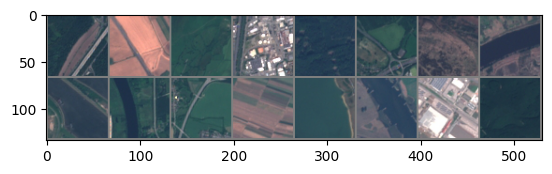

Labels: 3 3 5 4 1 3 2 8 8 8 3 0 9 8 4 1 7 0 4 5 5 9 1 5 3 3 9 0 6 0 9 4


In [254]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))
labels_lst = labels.tolist()
print('Labels:', ' '.join('%d' % j for j in labels_lst))

### Create the Network for Image Classification
The network built here follows has 2 layers of 2 consective CNNs with pooling in between, along with RELU active functions
It also has 2 linear activation functions to get the classifications


In [255]:
 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3,16,6,1)
        self.conv2 = nn.Conv2d(16,32,6,1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32,64,6,1)
        self.conv4 = nn.Conv2d(64,64,6,1)
        self.fc1 = nn.Linear(4096, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
 
nn_model = Network()
print(nn_model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


### Define the loss function
Here we are using Classification Cross-Entropy loss and an optimizer with Adam optimizer

In [256]:
#setup the devide to run on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

#Define the loss function and optimizer
loss_fx = nn.CrossEntropyLoss()
optimizer = Adam(nn_model.parameters(), lr=0.001, weight_decay=0.0001)

### Create supporting functions
* Save Trained Model
* Model Training
* Function to get the test accuracy
* Function to output the test result image following with its corresponding predicted label

In [257]:
# Function to save the model
def save_Model():
    path = "./trainmodel2.pth"
    torch.save(nn_model.state_dict(), path)

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Loop over the data and feed the inputs to the network to optimize.
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(0,epochs):  # loop over the dataset multiple times
        print("Running epoch: ",epoch+1)
        run_loss = 0.0
        run_acc = 0.0
        for i, (images, labels) in enumerate(trainloader, 0):
            images = Variable(images.to(device)) # get the training input images
            labels = Variable(labels.to(device)) # get the training input labels
            optimizer.zero_grad() # zero the parameter gradients
            outputs = nn_model(images) # run model to get predictions of the input images
            loss = loss_fx(outputs, labels) # compute the loss based on model output and real labels
            loss.backward() # backpropagate the loss
            optimizer.step()  # adjust parameters based on the calculated gradients

            run_loss += loss.item() #print statistics for every 1,000 images
            if i % 300 == 0:    
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, run_loss / 1000))
                run_loss = 0.0 # zero the loss
                
            
        # Compute and print the average accuracy of this epoch when tested over all the test images
        acc,cm = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (acc))
        #saving the model with best accuracy
        if acc > best_acc:
            save_Model()
            best_cm = cm
            best_acc = acc
    
    return best_cm

# Test accuracy metrics function
def testAccuracy():
    nn_model.eval()
    acc = 0.0
    tot = 0.0
    all_labels= []
    all_preds = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = nn_model(images) # run the model on the test set to predict labels
            _, predicted = torch.max(outputs.data, 1) # the label with the highest probability will be our prediction
            all_labels.append(labels.tolist())
            all_preds.append(predicted.tolist())
            tot += labels.size(0)
            acc += (predicted == labels).sum().item()
            
        
    # compute the accuracy over all test images
    cm_dict = {"Predictions":all_preds,"Actuals":all_labels}
    cm = pd.DataFrame(cm_dict)
    acc = (100 * acc / tot)
    return acc,cm

# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    images, labels = next(iter(testloader)) # get batch of images from the test DataLoader  
    imageshow(torchvision.utils.make_grid(images)) # show all images as one image grid
    labels_lst = labels.tolist()
    labels_lst = [label_map[x][:6] for x in  labels_lst]
    print('Real Labels:', ' '.join(j for j in labels_lst)) #show the real labels
    outputs = nn_model(images) 
    _, predicted = torch.max(outputs, 1)    
    pred_labels_lst = predicted.tolist()
    pred_labels_lst = [label_map[x][:6] for x in  pred_labels_lst]
    print('Pred Labels:', ' '.join(j for j in pred_labels_lst)) #show the predicted labels
    
    
#Label mapping
label_map = {0:"AnnualCrop",1:"Forest",2:"HerbaceousVegetation",3:"Highway",4:"Industrial",5:"Pasture",
            6:"PermanentCrop",7:"Residential",8:"River",9:"SeaLake"}

#testing the classes
def testClassess():
    class_correct = list(0. for i in range(num_labels))
    class_total = list(0. for i in range(num_labels))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(num_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

### Run the training model

In [258]:
conf_matrix_raw = train_model(4) #Train model and save the best one
print('Finished Training')

Running epoch:  1
[1,     1] loss: 0.002
[1,   301] loss: 0.521
[1,   601] loss: 0.410
For epoch 1 the test accuracy over the whole test set is 55 %
Running epoch:  2
[2,     1] loss: 0.001
[2,   301] loss: 0.317
[2,   601] loss: 0.283
For epoch 2 the test accuracy over the whole test set is 70 %
Running epoch:  3
[3,     1] loss: 0.001
[3,   301] loss: 0.246
[3,   601] loss: 0.236
For epoch 3 the test accuracy over the whole test set is 72 %
Running epoch:  4
[4,     1] loss: 0.001
[4,   301] loss: 0.197
[4,   601] loss: 0.194
For epoch 4 the test accuracy over the whole test set is 78 %
Finished Training


### Confusion Matrix
Confusion matrix to check the accuracy of our model


In [259]:
#Pre-processing the confusion matrix
conf_matrix = pd.DataFrame(columns=["Predictions","Actuals"])
conf_matrix["Predictions"] = conf_matrix_raw["Predictions"].explode()
conf_matrix["Actuals"] = conf_matrix_raw["Actuals"].explode()


accuracy = (conf_matrix["Predictions"] == conf_matrix["Actuals"]).sum()/len(conf_matrix)
print("Accuracy achieved by the best model is ",round(accuracy*100,2),"%") 

Accuracy achieved by the best model is  78.81 %


Let's look at the confusion matrix for the whole dataset (given by %age of total predictions per class)

In [265]:
conf_matrix_full = pd.crosstab(conf_matrix['Actuals'], conf_matrix['Predictions'], rownames=['Actual'], colnames=['Predicted'])
round(conf_matrix_full/conf_matrix_full.T.sum()*100,2)
conf_matrix_full

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,480,4,10,32,0,9,30,0,21,5
1,0,520,12,1,0,44,0,0,8,5
2,11,1,387,71,15,12,74,19,19,0
3,14,0,15,426,13,1,23,4,22,0
4,0,0,1,17,501,0,0,3,1,0
5,12,20,46,12,0,221,35,0,43,1
6,19,0,75,71,12,0,323,0,5,0
7,0,0,7,19,54,0,2,521,0,0
8,28,3,3,105,3,14,9,0,315,4


Accuracy at each class label for the test data set

In [261]:
temp_conf = conf_matrix_full.stack().reset_index().rename(columns={0:"num_predictions"})
right_preds = temp_conf[temp_conf["Actual"]==temp_conf["Predicted"]].rename(columns={"num_predictions":"Correct Predictions"})
wrong_preds = temp_conf[temp_conf["Actual"]!=temp_conf["Predicted"]]
wrong_preds = wrong_preds.groupby("Actual")["num_predictions"].sum().reset_index().rename(columns={"num_predictions":"Wrong Predictions"})
conf_matrix_byClass = right_preds.merge(wrong_preds,on=["Actual"])
conf_matrix_byClass["Accuracy"] = 100 * conf_matrix_byClass["Correct Predictions"]/(conf_matrix_byClass["Correct Predictions"]+conf_matrix_byClass["Wrong Predictions"])
conf_matrix_byClass = conf_matrix_byClass.drop("Predicted",axis=1).rename(columns={"Actual":"Class"})
conf_matrix_byClass["Class"] = conf_matrix_byClass["Class"].map(label_map)
conf_matrix_byClass

,Class,Correct Predictions,Wrong Predictions,Accuracy
0,AnnualCrop,480,111,81.218274
1,Forest,520,70,88.135593
2,HerbaceousVegetation,387,222,63.546798
3,Highway,426,92,82.239382
4,Industrial,501,22,95.793499
5,Pasture,221,169,56.666667
6,PermanentCrop,323,182,63.960396
7,Residential,521,82,86.401327
8,River,315,169,65.082645
9,SeaLake,562,25,95.741056


Couple of observations to be noted in this:
1) The model is able to predict Industrial images with a very high accuracy of ~96%
2) The model is alos able to correctly predict Forest, Residential, and SeaLake with good accuracy > 85%
2) The model is not performing so well on Vegetations, Pasture & Crop like data set, as can be inferred from the above confusion matrix for each class, it is getting confused between the two of them quite often as compared with other classes which makes sense.
4) With respect to River images, the model is getting confused between River and Highway a lot (around 20% of the times) which is quite strange

(Re-running the code might give slighlty varied accuracies and inferences, this inference is w.r.t to this run)

### Load the best model to run a test batch 
Test batch helps in visualizing and comparing the predicted outputs with the actuals labels for a sample of test set 
(in this case 32 samples are shown per batch; ran 5 batches for representation)

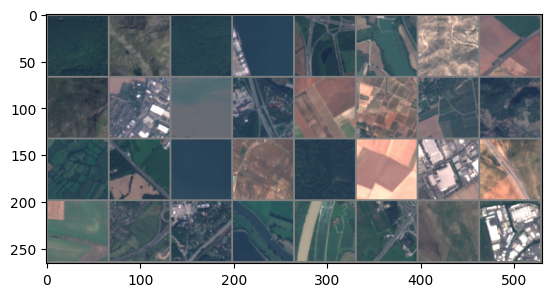

Real Labels: Forest Herbac Forest SeaLak Highwa River Herbac Highwa Herbac Indust SeaLak Highwa Annual Perman Perman Herbac Pastur Highwa SeaLak Perman Forest Annual Indust Highwa Annual Highwa Highwa River River Highwa Herbac Indust
Pred Labels: Forest Herbac Forest SeaLak River River Perman Annual Herbac Indust SeaLak Highwa Perman Perman Highwa Highwa River Highwa SeaLak Perman Forest Annual Indust Annual Annual Highwa Highwa River Perman Highwa Herbac Indust


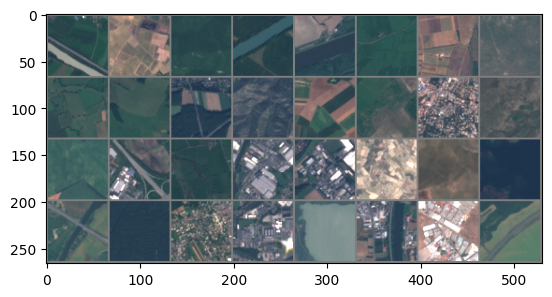

Real Labels: River Perman Forest River River Pastur Perman Herbac Pastur Pastur Highwa Herbac Annual Pastur Reside Herbac Annual Highwa Pastur Indust Indust Perman Herbac SeaLak Highwa Forest Reside Indust SeaLak River Indust Highwa
Pred Labels: Highwa Perman Forest River River Pastur Perman Herbac Pastur Pastur Highwa Highwa Annual Pastur Reside Herbac Pastur Highwa Forest Indust Indust Perman Herbac SeaLak Highwa Forest Reside Indust SeaLak Indust Indust Annual


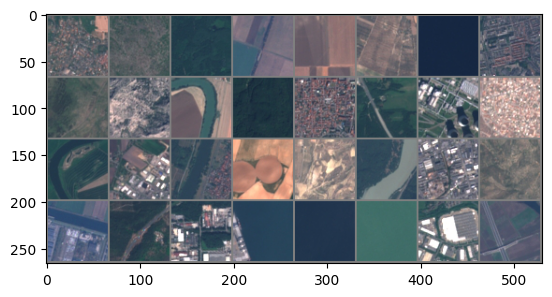

Real Labels: Reside Herbac Forest Annual Annual Perman SeaLak Reside Herbac Herbac River Forest Reside Highwa Indust Reside River Indust River Annual Perman River Indust Herbac River Highwa Indust SeaLak SeaLak SeaLak Indust Highwa
Pred Labels: Reside Herbac Forest Highwa Annual Herbac SeaLak Reside Herbac Highwa Annual Forest Reside Highwa Indust Reside Highwa Indust River Perman Perman River Indust Herbac Indust Highwa Indust SeaLak SeaLak SeaLak Indust Highwa


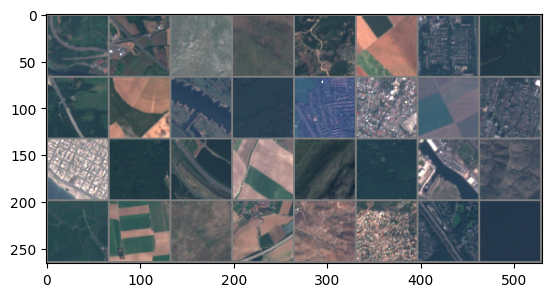

Real Labels: Highwa Highwa Herbac Herbac Herbac Annual Reside Forest Highwa Annual River Forest Reside Reside Annual Reside Reside Forest Highwa Annual Herbac Forest River Herbac Pastur Annual Herbac Highwa Herbac Reside Highwa SeaLak
Pred Labels: Highwa Perman Herbac Herbac Highwa Annual Reside Forest Highwa Annual River Forest Reside Indust Annual Reside Indust Forest Highwa Annual Herbac Forest Highwa Herbac River Annual Herbac Highwa Herbac Reside Highwa SeaLak


In [263]:
model = Network()
path = "trainmodel2.pth" #load the best model to give the predictions
model.load_state_dict(torch.load(path))
# Test with batch of images
for i in range(0,4):
    testBatch()